Dependency Install

In [ ]:
# !pip install numpy
# !pip install opencv
# !pip install yaml  ### may or may not need this if we define configs directly
# !pip install torch
# !pip install torchvision

Imports

In [ ]:

import os
import sys
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg
from torch.autograd import Variable
import time
import datetime
from torchvision import models as torchvision_models
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


DataLoading

In [ ]:

# Path for KITTI: /content/drive/MyDrive/Colab Notebooks/APPLIED_ML_PROJECTS/Dataset/KITTI/
#    For Training AND Testing: /content/drive/MyDrive/Colab Notebooks/APPLIED_ML_PROJECTS/Dataset/KITTI/training/

class ImageDataset:
    # We initialize the dataset with the path to the images and labels.
    def __init__(self, path):
        self.img_path = path + '/image_2'
        self.label_path = path + '/label_2'

        self.IDLst = [x.split('.')[0] for x in sorted(os.listdir(self.img_path))]
    # This method returns the data corresponding to a specific index.
    def __getitem__(self, index):
        tmp = {}
        #img = cv2.imread(self.img_path + '/%s.png'%self.IDLst[index], cv2.IMREAD_COLOR)
        with open(self.label_path + '/%s.txt'%self.IDLst[index], 'r') as f:
            buf = []
            for line in f:
                line = line[:-1].split(' ')
                for i in range(1, len(line)):
                    line[i] = float(line[i])
                Class = line[0]
                Alpha = line[3] / np.pi * 180
                Ry = line[14] / np.pi * 180
                top_left = (int(round(line[4])), int(round(line[5])))
                bottom_right = (int(round(line[6])), int(round(line[7])))
                Box_2D = [top_left, bottom_right]
                Dimension = [line[8], line[9], line[10]] # height, width, length
                Location = [line[11], line[12], line[13]] # x, y, z
                ThetaRay = (np.arctan2(Location[2], Location[0])) / np.pi * 180
                LocalAngle = 360 - (ThetaRay + Ry)
                if LocalAngle > 360:
                    LocalAngle -= 360

                LocalAngle = LocalAngle / 180 * np.pi

                if LocalAngle < 0:
                    LocalAngle += 2 * np.pi
                buf.append({
                        'Class': Class,
                        'Box_2D': Box_2D,
                        'Dimension': Dimension,
                        'Location': Location,
                        'Alpha': Alpha,
                        'Ry': Ry,
                        'ThetaRay': ThetaRay,
                        'LocalAngle': LocalAngle
                    })

        tmp['ID'] = self.IDLst[index]
        #tmp['Image'] = img
        tmp['Label'] = buf
        return tmp
    # This method retrieves and processes an image from the dataset.
    def GetImage(self, idx):
        name = '%s/%s.png'%(self.img_path, self.IDLst[idx])
        img = cv2.imread(name, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float64) / 255
        img[:, :, 0] = (img[:, :, 0] - 0.406) / 0.225
        img[:, :, 1] = (img[:, :, 1] - 0.456) / 0.224
        img[:, :, 2] = (img[:, :, 2] - 0.485) / 0.229
        return img
    # Returns the total number of items in the dataset.
    def __len__(self):
        return len(self.IDLst)

class BatchDataset:
    # We chose to implement a dataset wrapper for batching and processing.
    def __init__(self, imgDataset, batchSize = 1, bins = 3, overlap = 25/180.0 * np.pi, mode='train'):
        self.imgDataset = imgDataset
        self.batchSize = batchSize
        self.bins = bins
        self.overlap = overlap
        self.mode = mode
        self.imgID = None
        # We determine the center angles for the bins.
        centerAngle = np.zeros(bins)
        interval = 2 * np.pi / bins
        for i in range(1, bins):
            centerAngle[i] = i * interval
        self.centerAngle = centerAngle
        #print centerAngle / np.pi * 180
        self.intervalAngle = interval
        # We generate batch information based on the dataset.
        self.info = self.getBatchInfo()
        self.Total = len(self.info)
        # We differentiate between training and evaluation modes.
        if mode == 'train':
            self.idx = 0
            self.num_of_patch = 35570
        else:
            self.idx = 35570
            self.num_of_patch = 5000
        #print len(self.info)
        #print self.info


    # This method gathers batch information from the dataset.
    def getBatchInfo(self):

        data = []
        total = len(self.imgDataset)
        centerAngle = self.centerAngle
        intervalAngle = self.intervalAngle
        for idx, one in enumerate(self.imgDataset):
            ID = one['ID']
            #img = one['Image']
            allLabel = one['Label']
            # We compute confidence scores based on the orientation.
            for label in allLabel:
                if label['Class'] != 'DontCare':
                    LocalAngle = label['LocalAngle']
                    confidence = np.zeros(self.bins)
                    confidence_multi = np.zeros(self.bins)
                    # We calculate confidence scores for each bin.
                    for i in range(self.bins):
                        diff = abs(centerAngle[i] - LocalAngle)
                        if diff > np.pi:
                            diff = 2 * np.pi - diff
                        if diff <= intervalAngle / 2 + self.overlap:
                            confidence_multi[i] = 1
                        if diff < intervalAngle / 2:
                            confidence[i] = 1
                    n = np.sum(confidence)
                    # We append calculated data for each label.
                    data.append({
                                'ID': ID, # img ID
                                'Index': idx, # id in Imagedataset
                                'Box_2D': label['Box_2D'],
                                'Dimension': label['Dimension'],
                                'Location': label['Location'],
                                'LocalAngle': LocalAngle,
                                'Confidence': confidence,
                                'ConfidenceMulti': confidence_multi,
                                'Ntheta':n,
                                'Ry': label['Ry'],
                                'ThetaRay': label['ThetaRay']
                            })
        return data

    # We retrieve the next batch of data for processing.
    def Next(self):
        # Data preprocessing steps are applied here.
        # Implementation continues with image cropping, resizing, and normalization.
        # Batching logic is implemented here.
        batch = np.zeros([self.batchSize, 3, 224, 224], np.float64)
        confidence = np.zeros([self.batchSize, self.bins], np.float64)
        confidence_multi = np.zeros([self.batchSize, self.bins], np.float64)
        ntheta = np.zeros(self.batchSize, np.float64)
        angleDiff = np.zeros([self.batchSize, self.bins], np.float64)
        dim = np.zeros([self.batchSize, 3], np.float64)
        record = None
        for one in range(self.batchSize):
            data = self.info[self.idx]
            imgID = data['Index']
            if imgID != record:
                img = self.imgDataset.GetImage(imgID)
            pt1 = data['Box_2D'][0]
            pt2 = data['Box_2D'][1]
            crop = img[pt1[1]:pt2[1]+1, pt1[0]:pt2[0]+1]
            crop = cv2.resize(src=crop, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
            batch[one, 0, :, :] = crop[:, :, 2]
            batch[one, 1, :, :] = crop[:, :, 1]
            batch[one, 2, :, :] = crop[:, :, 0]
            confidence[one, :] = data['Confidence'][:]
            confidence_multi[one, :] = data['ConfidenceMulti'][:]

            ntheta[one] = data['Ntheta']
            angleDiff[one, :] = data['LocalAngle'] - self.centerAngle
            dim[one, :] = data['Dimension']
            if self.mode == 'train':
                if self.idx + 1 < self.num_of_patch:
                    self.idx += 1
                else:
                    self.idx = 0
            else:
                if self.idx + 1 < self.Total:
                    self.idx += 1
                else:
                    self.idx = 35570
        return batch, confidence, confidence_multi, angleDiff, dim
    # This method is specifically for evaluation, providing one batch at a time.
    def EvalBatch(self):
    # Similar to Next(), but tailored for evaluation purposes.
        batch = np.zeros([1, 3, 224, 224], np.float64)
        info = self.info[self.idx]
        imgID = info['Index']
        if imgID != self.imgID:
            self.img = self.imgDataset.GetImage(imgID)
            self.imgID = imgID
        pt1 = info['Box_2D'][0]
        pt2 = info['Box_2D'][1]
        crop = self.img[pt1[1]:pt2[1]+1, pt1[0]:pt2[0]+1]
        crop = cv2.resize(src = crop, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        batch[0, 0, :, :] = crop[:, :, 2]
        batch[0, 1, :, :] = crop[:, :, 1]
        batch[0, 2, :, :] = crop[:, :, 0]

        if self.mode == 'train':
            if self.idx + 1 < self.num_of_patch:
                self.idx += 1
            else:
                self.idx = 0
        else:
            if self.idx + 1 < self.Total:
                self.idx += 1
            else:
                self.idx = 35570
        return batch, self.centerAngle, info

Testing the Dataset loading

Total number of images in the dataset: 7481
Data for sample index 0: {'ID': '000000', 'Label': [{'Class': 'Pedestrian', 'Box_2D': [(712, 143), (811, 308)], 'Dimension': [1.89, 0.48, 1.2], 'Location': [1.84, 1.47, 8.41], 'Alpha': -11.459155902616464, 'Ry': 0.5729577951308232, 'ThetaRay': 77.6588809564437, 'LocalAngle': 4.917782141075321}]}


Image shape: (370, 1224, 3)


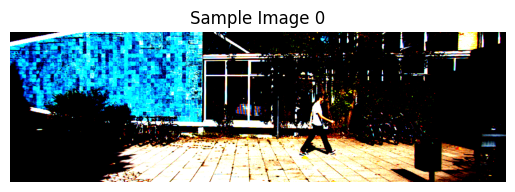

Label data keys: dict_keys(['Class', 'Box_2D', 'Dimension', 'Location', 'Alpha', 'Ry', 'ThetaRay', 'LocalAngle'])
Sample label data passed basic checks.
Images are normalized for training. So the images will appear saturated. Normalizing transforms the input data to have zero mean and unit variance, which helps in converging faster during training.


In [ ]:


def test_dataset_loading(image_dataset):
    print(f"Total number of images in the dataset: {len(image_dataset)}")

    # Test loading the first image and its labels
    sample_index = 0
    sample_data = image_dataset[sample_index]
    print(f"Data for sample index {sample_index}: {sample_data}")

    # Load an image using the dataset's method
    image = image_dataset.GetImage(sample_index)
    print(f"Image shape: {image.shape}")

    # Convert the image from BGR to RGB for displaying
    #image_rgb = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image)
    plt.title(f"Sample Image {sample_index}")
    plt.axis('off')  # Hide axis for clarity
    plt.show()

    # Check the structure of the loaded label data
    assert 'ID' in sample_data, "'ID' not in the sample data"
    assert 'Label' in sample_data, "'Label' not in the sample data"

    print("Label data keys:", sample_data['Label'][0].keys())

    # Check the dimensions and types of the label data
    for label in sample_data['Label']:
        assert isinstance(label['Class'], str), "'Class' is not a string"
        assert isinstance(label['Box_2D'], list), "'Box_2D' is not a list"
        assert len(label['Dimension']) == 3, "'Dimension' does not have 3 elements"
        assert len(label['Location']) == 3, "'Location' does not have 3 elements"
        print("Sample label data passed basic checks.")

# Path for KITTI: /content/drive/MyDrive/Colab Notebooks/APPLIED_ML_PROJECTS/Dataset/KITTI
#    For Training AND Testing: /content/drive/MyDrive/Colab Notebooks/APPLIED_ML_PROJECTS/Dataset/KITTI/training
dataset_path = '/content/drive/MyDrive/Colab Notebooks/APPLIED_ML_PROJECTS/Dataset/KITTI/training'  # Update this path to your dataset location
image_dataset = ImageDataset(dataset_path)
test_dataset_loading(image_dataset)
print("Images are normalized for training. So the images will appear saturated. Normalizing transforms the input data to have zero mean and unit variance, which helps in converging faster during training.")


Model Architecture

In [ ]:


# Orientation Loss Function
def OrientationLoss(orient, angleDiff, confGT):
    """
    Calculate orientation loss for the estimated orientation of the 3D bounding box.

    Parameters:
    - orient: Predicted orientation in terms of sine and cosine (shape: [batch, bins, 2]).
    - angleDiff: Ground truth angle minus the center angle of each bin (shape: [batch, bins]).
    - confGT: Confidence for ground truth bin (binary vector indicating the correct bin).

    Returns:
    - The orientation loss for the batch.
    """
    [batch, _, bins] = orient.size()
    cos_diff = torch.cos(angleDiff)
    sin_diff = torch.sin(angleDiff)
    cos_ori = orient[:, :, 0]
    sin_ori = orient[:, :, 1]
    mask1 = (confGT != 0)
    mask2 = (confGT == 0)
    count = torch.sum(mask1, dim=1)
    tmp = cos_diff * cos_ori + sin_diff * sin_ori
    tmp[mask2] = 0
    total = torch.sum(tmp, dim = 1)
    count = count.type(torch.FloatTensor).cuda()
    total = total / count
    return -torch.sum(total) / batch

# Neural Network Model for 3D Bounding Box Estimation
class Model(nn.Module):
    def __init__(self, features=None, bins=2, w=0.4):
        """
        Initialize the model for 3D bounding box estimation.

        Parameters:
        - features: Pretrained feature extractor (e.g., VGG).
        - bins: Number of bins to use for angle discretization.
        - w: Weight parameter for orientation loss.
        """
        super(Model, self).__init__()
        self.bins = bins
        self.w = w
        self.features = features

        # Orientation branch of the network to estimate the orientation of the object
        self.orientation = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),  # Flatten the features and feed into dense layers
            nn.ReLU(True),  # Non-linearity
            nn.Dropout(),  # Regularization
            nn.Linear(256, 256),  # Additional dense layer
            nn.ReLU(True),  # Non-linearity
            nn.Dropout(),  # Regularization
            nn.Linear(256, bins * 2)  # Output layer to predict sin and cos values for each bin
        )

        # Confidence branch to estimate the confidence of each bin
        self.confidence = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),  # Flatten the features and feed into dense layers
            nn.ReLU(True),  # Non-linearity
            nn.Dropout(),  # Regularization
            nn.Linear(256, 256),  # Additional dense layer
            nn.ReLU(True),  # Non-linearity
            nn.Dropout(),  # Regularization
            nn.Linear(256, bins),  # Output layer for bin confidences
            #nn.Softmax(dim=1)  # Added Softmax because KITTI uses objects that are distinct and mutually exclusive like person car bike
            # nn.Softmax or nn.Sigmoid could be used here depending on the approach
        )

        # Dimension branch to estimate the dimensions of the 3D bounding box
        self.dimension = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),  # Flatten the features and feed into dense layers
            nn.ReLU(True),  # Non-linearity
            nn.Dropout(),  # Regularization
            nn.Linear(512, 512),  # Additional dense layer
            nn.ReLU(True),  # Non-linearity
            nn.Dropout(),  # Regularization
            nn.Linear(512, 3)  # Output layer for dimensions (width, height, length)
        )

    def forward(self, x):
        """
        Forward pass of the model.

        Parameters:
        - x: Input image batch.

        Returns:
        - Tuple of orientation, confidence, and dimensions predictions.
        """
        x = self.features(x)  # Extract features using the pretrained model
        x = x.view(-1, 512 * 7 * 7)  # Flatten the features

        # Predict orientation, confidence, and dimensions
        orientation = self.orientation(x)
        orientation = orientation.view(-1, self.bins, 2)
        orientation = F.normalize(orientation, dim=2)  # Normalize the sine and cosine predictions
        confidence = self.confidence(x)  # Predict bin confidences
        dimension = self.dimension(x)  # Predict dimensions

        return orientation, confidence, dimension


Training + Early Stopping Class

In [ ]:
store_path = '/content/drive/MyDrive/Colab Notebooks/APPLIED_ML_PROJECTS/models'
if not os.path.isdir(store_path):
    os.mkdir(store_path)

model_lst = [x for x in sorted(os.listdir(store_path)) if x.endswith('.pkl')]

path = '/content/drive/MyDrive/Colab Notebooks/APPLIED_ML_PROJECTS/Dataset/KITTI/'
epochs = 2
batches = 2
bins = 12
alpha = 1
w = 8
# epochs = 8
# batches = 2
# bins = 1
# alpha = 1
# w = 8


data = ImageDataset(path + '/training')
data = BatchDataset(data, batches, bins)

In [ ]:

# if len(model_lst) == 0:
print('No previous model found, start training')
# We use VGG19 with batch normalization as our feature extractor.
vgg = torchvision_models.vgg19_bn(pretrained=True)
# We instantiate our model with the VGG19 features and the specified number of bins.
model = Model(features=vgg.features, bins=bins).cuda()
# else:
#     print(f'Find previous model {model_lst[-1]}')
#     vgg = torchvision_models.vgg19_bn(pretrained=False)
#     model = Model(features=vgg.features, bins=bins).cuda()
#     params = torch.load(store_path + '/%s'%model_lst[-1])
#     model.load_state_dict(params)

opt_SGD = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
dim_LossFunc = nn.MSELoss().cuda()
conf_LossFunc = nn.CrossEntropyLoss().cuda()


# opt_Adam = optim.Adam(model.parameters(), lr=0.0001)  # Starting with a higher learning rate
# dim_LossFunc = nn.MSELoss().cuda()
# conf_LossFunc = nn.CrossEntropyLoss().cuda()

# Learning rate scheduler - reduces the learning rate when the loss plateaus
# lr_scheduler = ReduceLROnPlateau(opt_Adam, mode='min', factor=0.1, patience=5)

iter_each_time = round(float(data.num_of_patch) / batches)
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(int(iter_each_time)):
        batch, confidence, confidence_multi, angleDiff, dimGT = data.Next()

       # Convert the batch data to PyTorch tensors and move them to the GPU.
        confidence_arg = np.argmax(confidence, axis = 1)
        batch = Variable(torch.FloatTensor(batch), requires_grad=False).cuda()
        confidence = Variable(torch.LongTensor(confidence.astype(np.int64)), requires_grad=False).cuda()
        confidence_multi = Variable(torch.LongTensor(confidence_multi.astype(np.int64)), requires_grad=False).cuda()
        angleDiff = Variable(torch.FloatTensor(angleDiff), requires_grad=False).cuda()
        dimGT = Variable(torch.FloatTensor(dimGT), requires_grad=False).cuda()
        confidence_arg = Variable(torch.LongTensor(confidence_arg.astype(np.int64)), requires_grad=False).cuda()

        # Forward pass: compute the model's predictions based on the batch.
        [orient, conf, dim] = model(batch)
        conf_loss = conf_LossFunc(conf, confidence_arg)
        orient_loss = OrientationLoss(orient, angleDiff, confidence_multi)
        dim_loss = dim_LossFunc(dim, dimGT)
        loss_theta = conf_loss + w * orient_loss
        loss = alpha * dim_loss + loss_theta

        if i % 1000 == 0:
            c_l = conf_loss.cpu().data.numpy()
            o_l = orient_loss.cpu().data.numpy()
            d_l = dim_loss.cpu().data.numpy()
            t_l = loss.cpu().data.numpy()
            now = datetime.datetime.now()
            now_s = now.strftime('%Y-%m-%d-%H-%M-%S')
            print(f'------- {now_s} Epoch {epoch:02d} -------')
            print(f'Confidence Loss: {c_l}')
            print(f'Orientation Loss: {o_l}')
            print(f'Dimension Loss: {d_l}')
            print(f'Total Loss: {t_l}')

            print('-----------------------------')
        # if 0 <= t_l < 2:
        #   break;

        opt_SGD.zero_grad()
        loss.backward()
        opt_SGD.step()
        # opt_Adam.zero_grad()
        # loss.backward()
        # opt_Adam.step()

        # Update learning rate based on the loss after each epoch
        # lr_scheduler.step(loss)

    now = datetime.datetime.now()
    now_s = now.strftime('%Y-%m-%d-%H-%M-%S')
    name = store_path + '/model_%s.pkl'%now_s
    torch.save(model.state_dict(), name)
    # break;

# # Load the last checkpoint with the best model
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/APPLIED_ML_PROJECTS/models/early_stopping_model.pth'))

No previous model found, start training


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:06<00:00, 84.0MB/s]


------- 2024-04-08-01-15-44 Epoch 00 -------
Confidence Loss: 2.356574296951294
Orientation Loss: -0.06728291511535645
Dimension Loss: 28.489347457885742
Total Loss: 30.307659149169922
-----------------------------
------- 2024-04-08-01-22-04 Epoch 00 -------
Confidence Loss: 2.854548931121826
Orientation Loss: -0.9081146717071533
Dimension Loss: 0.38430196046829224
Total Loss: -4.026066303253174
-----------------------------
------- 2024-04-08-01-27-46 Epoch 00 -------
Confidence Loss: 0.9812999367713928
Orientation Loss: -0.9597980976104736
Dimension Loss: 0.1549929976463318
Total Loss: -6.5420918464660645
-----------------------------
------- 2024-04-08-01-33-45 Epoch 00 -------
Confidence Loss: 2.787400722503662
Orientation Loss: -0.8468437790870667
Dimension Loss: 0.41543030738830566
Total Loss: -3.5719192028045654
-----------------------------
------- 2024-04-08-01-39-36 Epoch 00 -------
Confidence Loss: 0.5087684392929077
Orientation Loss: -0.9856145977973938
Dimension Loss: 1.0

Model Evaluation

In [ ]:
store_path = '/content/drive/MyDrive/Colab Notebooks/APPLIED_ML_PROJECTS/models'
if not os.path.isdir(store_path):
    print ('No folder named \"models/\"')
    exit()

model_lst = [x for x in sorted(os.listdir(store_path)) if x.endswith('.pkl')]

# Only evaluates the last loaded model
path = '/content/drive/MyDrive/Colab Notebooks/APPLIED_ML_PROJECTS/Dataset/KITTI/'
# epochs = 8
# batches = 8
# bins = 3
# alpha = 0.8
# w = 0.8
epochs = 2
batches = 2
bins = 12
alpha = 1
w = 8




if len(model_lst) == 0:
    print ('No previous model found, please check it')
    exit()
# else:
#     print(f'Found previous model {model_lst[-1]}')
#     vgg_model = torchvision_models.vgg19_bn(pretrained=False)
#     model = Model(features=vgg_model.features, bins=bins).cuda()

#     params = torch.load(store_path + '/%s'%model_lst[-1])
#     model.load_state_dict(params)
#     model.eval()

for idx, model_name in enumerate(model_lst):

    # Use different parameters based on the model's position in the list
    if idx < 2:  # For the first two models
        bins = 12
    else:  # For the last two models
        bins = 2

    print(f'Evaluating model {model_name}...')
    model_path = os.path.join(store_path, model_name)
    vgg_model = torchvision_models.vgg19_bn(pretrained=False)
    model = Model(features=vgg_model.features, bins=bins).cuda()
    params = torch.load(model_path)
    model.load_state_dict(params)
    model.eval()

    data = ImageDataset(path + '/training')
    data = BatchDataset(data, batches, bins, mode = 'eval')

    angle_error = []
    dimension_error = []
    for i in range(data.num_of_patch):
        batch, centerAngle, info = data.EvalBatch()
        dimGT = info['Dimension']
        angle = info['LocalAngle'] / np.pi * 180
        Ry = info['Ry']
        batch = Variable(torch.FloatTensor(batch), requires_grad=False).cuda()

        [orient, conf, dim] = model(batch)
        orient = orient.cpu().data.numpy()[0, :, :]
        conf = conf.cpu().data.numpy()[0, :]
        dim = dim.cpu().data.numpy()[0, :]
        argmax = np.argmax(conf)
        orient = orient[argmax, :]
        cos = orient[0]
        sin = orient[1]

        theta = np.arctan2(sin, cos) / np.pi * 180
        theta = theta + centerAngle[argmax] / np.pi * 180
        theta = 360 - info['ThetaRay'] - theta
        if theta > 0: theta -= int(theta / 360) * 360
        elif theta < 0: theta += (int(-theta / 360) + 1) * 360
        if Ry > 0: Ry -= int(Ry / 360) * 360
        elif Ry < 0: Ry += (int(-Ry / 360) + 1) * 360

        theta_error = abs(Ry - theta)
        if theta_error > 180: theta_error = 360 - theta_error
        angle_error.append(theta_error)

        dim_error = np.mean(abs(np.array(dimGT) - dim))
        dimension_error.append(dim_error)

        if i % 1000 == 0 or i == data.num_of_patch - 1:  # Print at intervals and the last item
            print(f'---- {model_name} Evaluation {i:05d}/{data.num_of_patch} ----')
            print(f'Angle error: {np.mean(angle_error)}')
            print(f'Dimension error: {np.mean(dimension_error)}')

    print(f'Final Evaluation for {model_name}:')
    print(f'Average Angle Error: {np.mean(angle_error)}')
    print(f'Average Dimension Error: {np.mean(dimension_error)}\n')

Evaluating model NN_ALPHA.pkl...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---- NN_ALPHA.pkl Evaluation 00000/5000 ----
Angle error: 0.24858376128821646
Dimension error: 1.9056887849171957
---- NN_ALPHA.pkl Evaluation 01000/5000 ----
Angle error: 18.068459844684284
Dimension error: 0.3458790360162388
---- NN_ALPHA.pkl Evaluation 02000/5000 ----
Angle error: 18.496630023444528
Dimension error: 0.3592509278142212
---- NN_ALPHA.pkl Evaluation 03000/5000 ----
Angle error: 18.53236880680856
Dimension error: 0.3528823707994323
---- NN_ALPHA.pkl Evaluation 04000/5000 ----
Angle error: 18.152097860742547
Dimension error: 0.3527577621057055
---- NN_ALPHA.pkl Evaluation 04999/5000 ----
Angle error: 17.770877562163864
Dimension error: 0.3515150227899551
Final Evaluation for NN_ALPHA.pkl:
Average Angle Error: 17.770877562163864
Average Dimension Error: 0.3515150227899551

Evaluating model NN_BETA.pkl...
---- NN_BETA.pkl Evaluation 00000/5000 ----
Angle error: 1.635373016767801
Dimension error: 0.568677879969279
